# Sales forecasting on the M5 Walmart data set from Kaggle 

## Overview/ Problem Statement

### Given sales data from roughly 10 stores across Texas, Wisconsin and California, predict sales and inventory levels for the next 28 days.

The data that we have is divided into 3 .csv f iles.  

sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]

sell_prices.csv - Contains information about the price of the products sold per store and date.

calendar.csv - Contains information about the dates on which the products are sold, such as holidays, sales, specials, SNAP days, etc.

Load the data from Kaggle and parse them into dataframes:

In [10]:
import pandas as pd
import numpy as np 
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib import dates as mat_dates
from matplotlib.ticker import FuncFormatter, PercentFormatter

The data is availible at https://www.kaggle.com/competitions/m5-forecasting-accuracy/data if you would like to follow along.

In [3]:
calendar_df = pd.read_csv('calendar.csv')
sales_df = pd.read_csv('sales_train_validation.csv')
prices_df = pd.read_csv('sell_prices.csv')

In [5]:
print(calendar_df.shape)
print(calendar_df.head())


(1969, 14)
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  


Notes about Calendar_df:
14 different metrics over 1969 days.  
wday is an integer encoding of the days of the week
month is an integer encoding of the months of the year.  
Event_types refer to sales or special holidays.  This column has a bunch of NaN's we will need to deal with


Snap column refer to "Snap" days.  
SNAP stands for supplemental nutrition assistance program.  It is designed to provide food assistance for low income families.  It is a federal program administered by the states.   The families enrolled in SNAP recieve their assistance on a bank card over 10 days each month, with 1/10 of all families recieving their funds on one of the 10 days.

In [6]:
print(sales_df.shape)
print(sales_df.head())


(30490, 1919)
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1

30490 rows and 1919 columns. So, this is the number of sales for each item(30490 items) over 1913 days.  We also have item ID's, department ID's, category ID's, and Store ID's.  We can calculate sales to each of these different levels.  

In [7]:
print(prices_df.shape)
print(prices_df.head())

(6841121, 4)
  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26


price_df encodes the sale price for an item for each week in the dataset.  Each item will have multiple sales prices depending on how its price has changed over time.

# Data Exploration

We are predicting sales for all the stores and all items.  That is a great place to start in visualizing this data. Let's see if there are any patters in total sales among all items in all stores per day.  To do this properly, we will need to merge this with the calender_df (or atleast the days columns from calender_df

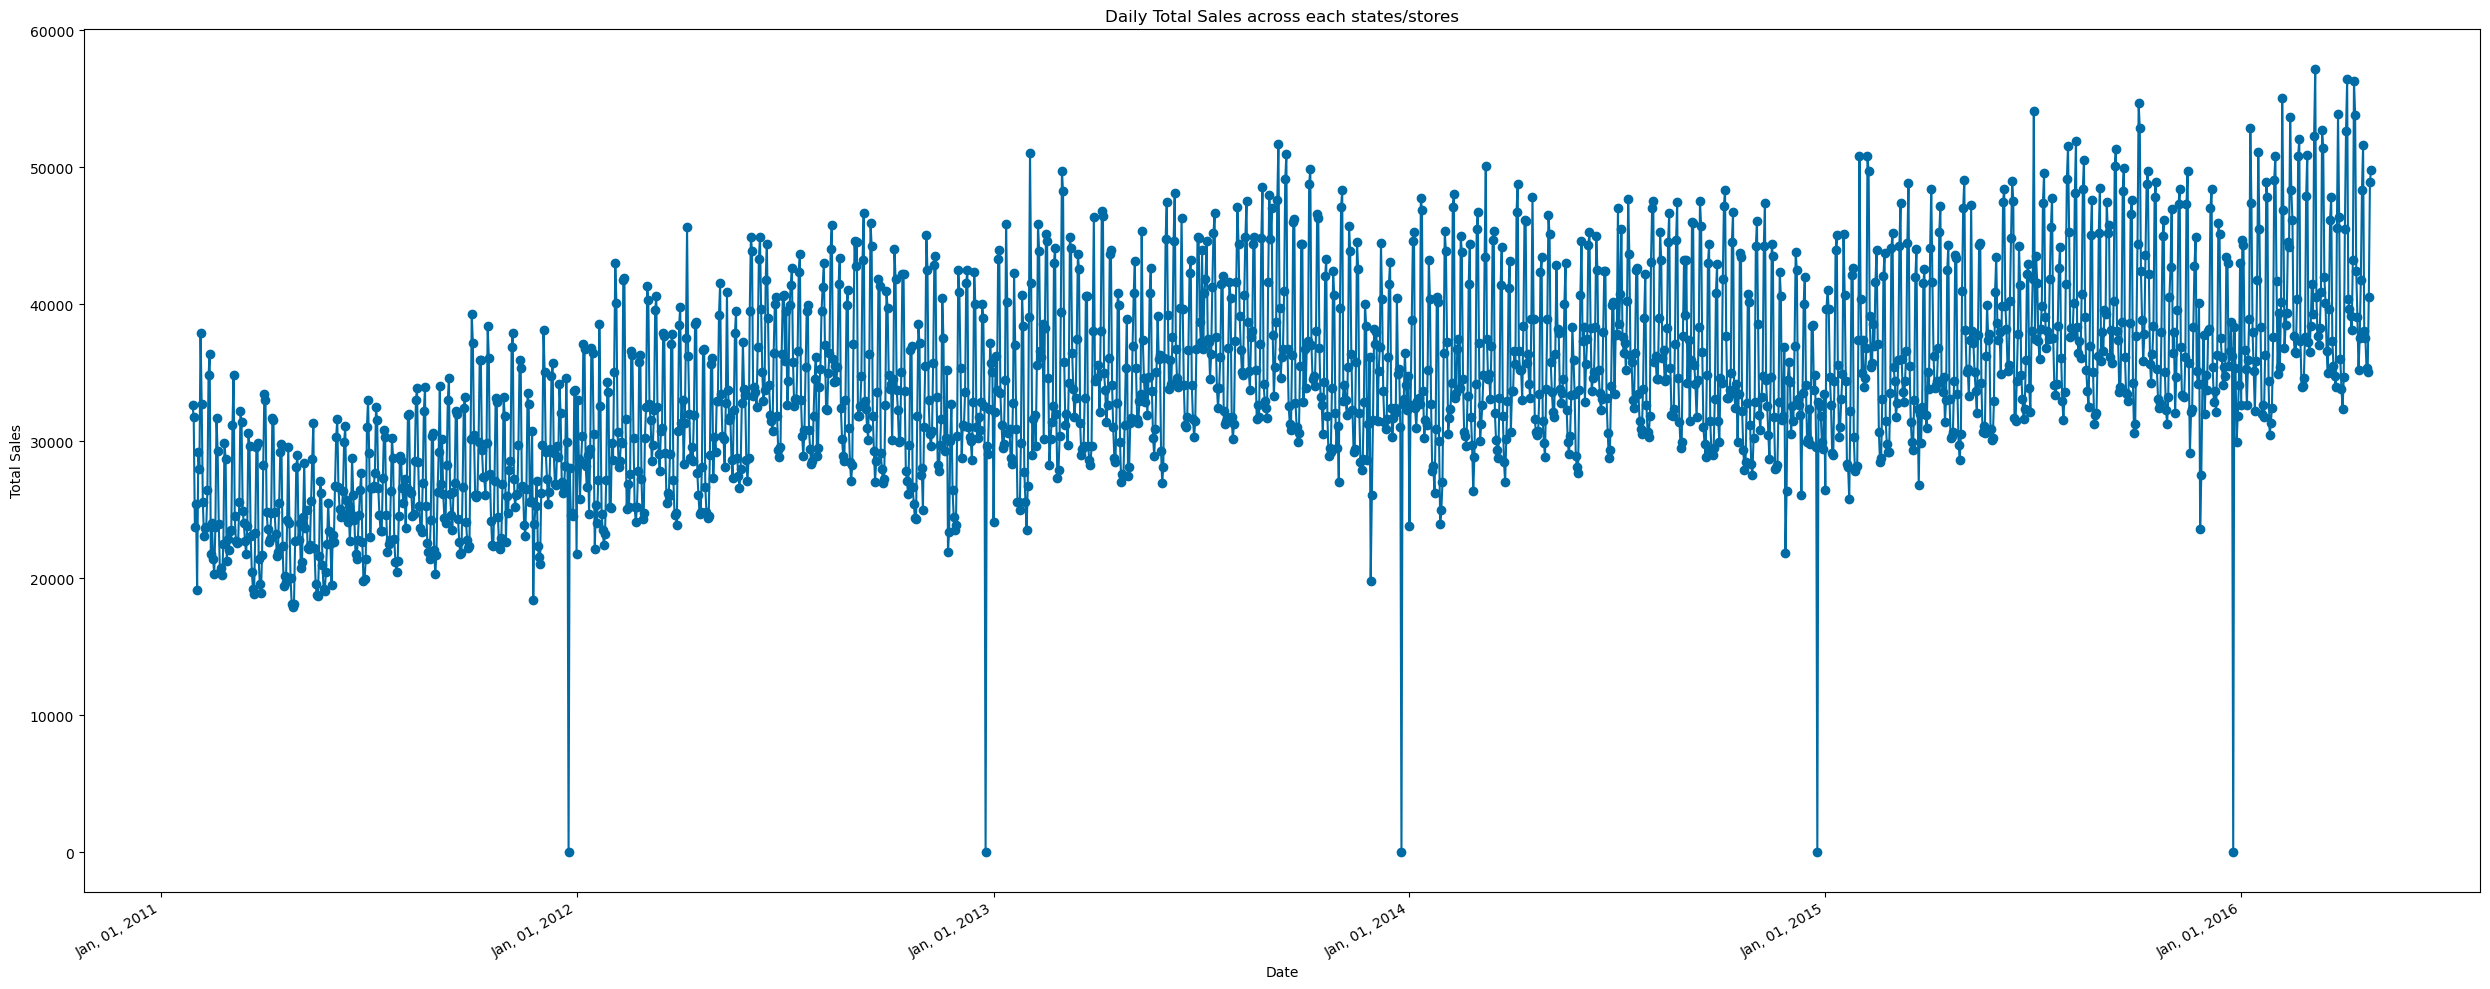

In [12]:
total_sales_per_day = sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum'])
total_sales_per_day = total_sales_per_day.T.reset_index()
total_sales_per_day.rename(columns={'sum':'Total_Sales','index':'d'}, inplace=True)
total_sales_per_day = total_sales_per_day.merge(calendar_df,on='d',how='left')
total_sales_per_day = total_sales_per_day[['date','Total_Sales']]
total_sales_per_day['date'] = pd.to_datetime(total_sales_per_day['date'])
dates = total_sales_per_day['date']
sales = total_sales_per_day['Total_Sales']

plt.style.use('tableau-colorblind10')
plt.plot_date(dates, sales, linestyle='solid')
plt.gcf().autofmt_xdate()
date_format = mat_dates.DateFormatter('%b, %d, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().set_size_inches(25, 10)
plt.title('Daily Total Sales across each states/stores')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

Looking at this a couple things stand out.  First, there is a clear upward trend in the time series.  Gross sales are increasing over time.  

There are zero sales on, what appears to be, the same day each year.  This date is around Christmas or New Years, which would make sense, as some stores do close on Christmas, or New Years day

There seems to be a rising and falling pattern between each year, so we will examine the dataset in a more fine grained manner.

First, let's look at each year seperately. 

/var/folders/3r/d4dktpdd1pb4hllgb_5fkm300000gn/T/ipykernel_1970/2139764335.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(total_sales_per_day.iloc[gby_values_list[i]]['date'], total_sales_per_day.iloc[gby_values_list[i]]['Total_Sales'],linestyle='solid',linewidth=1,marker='.')


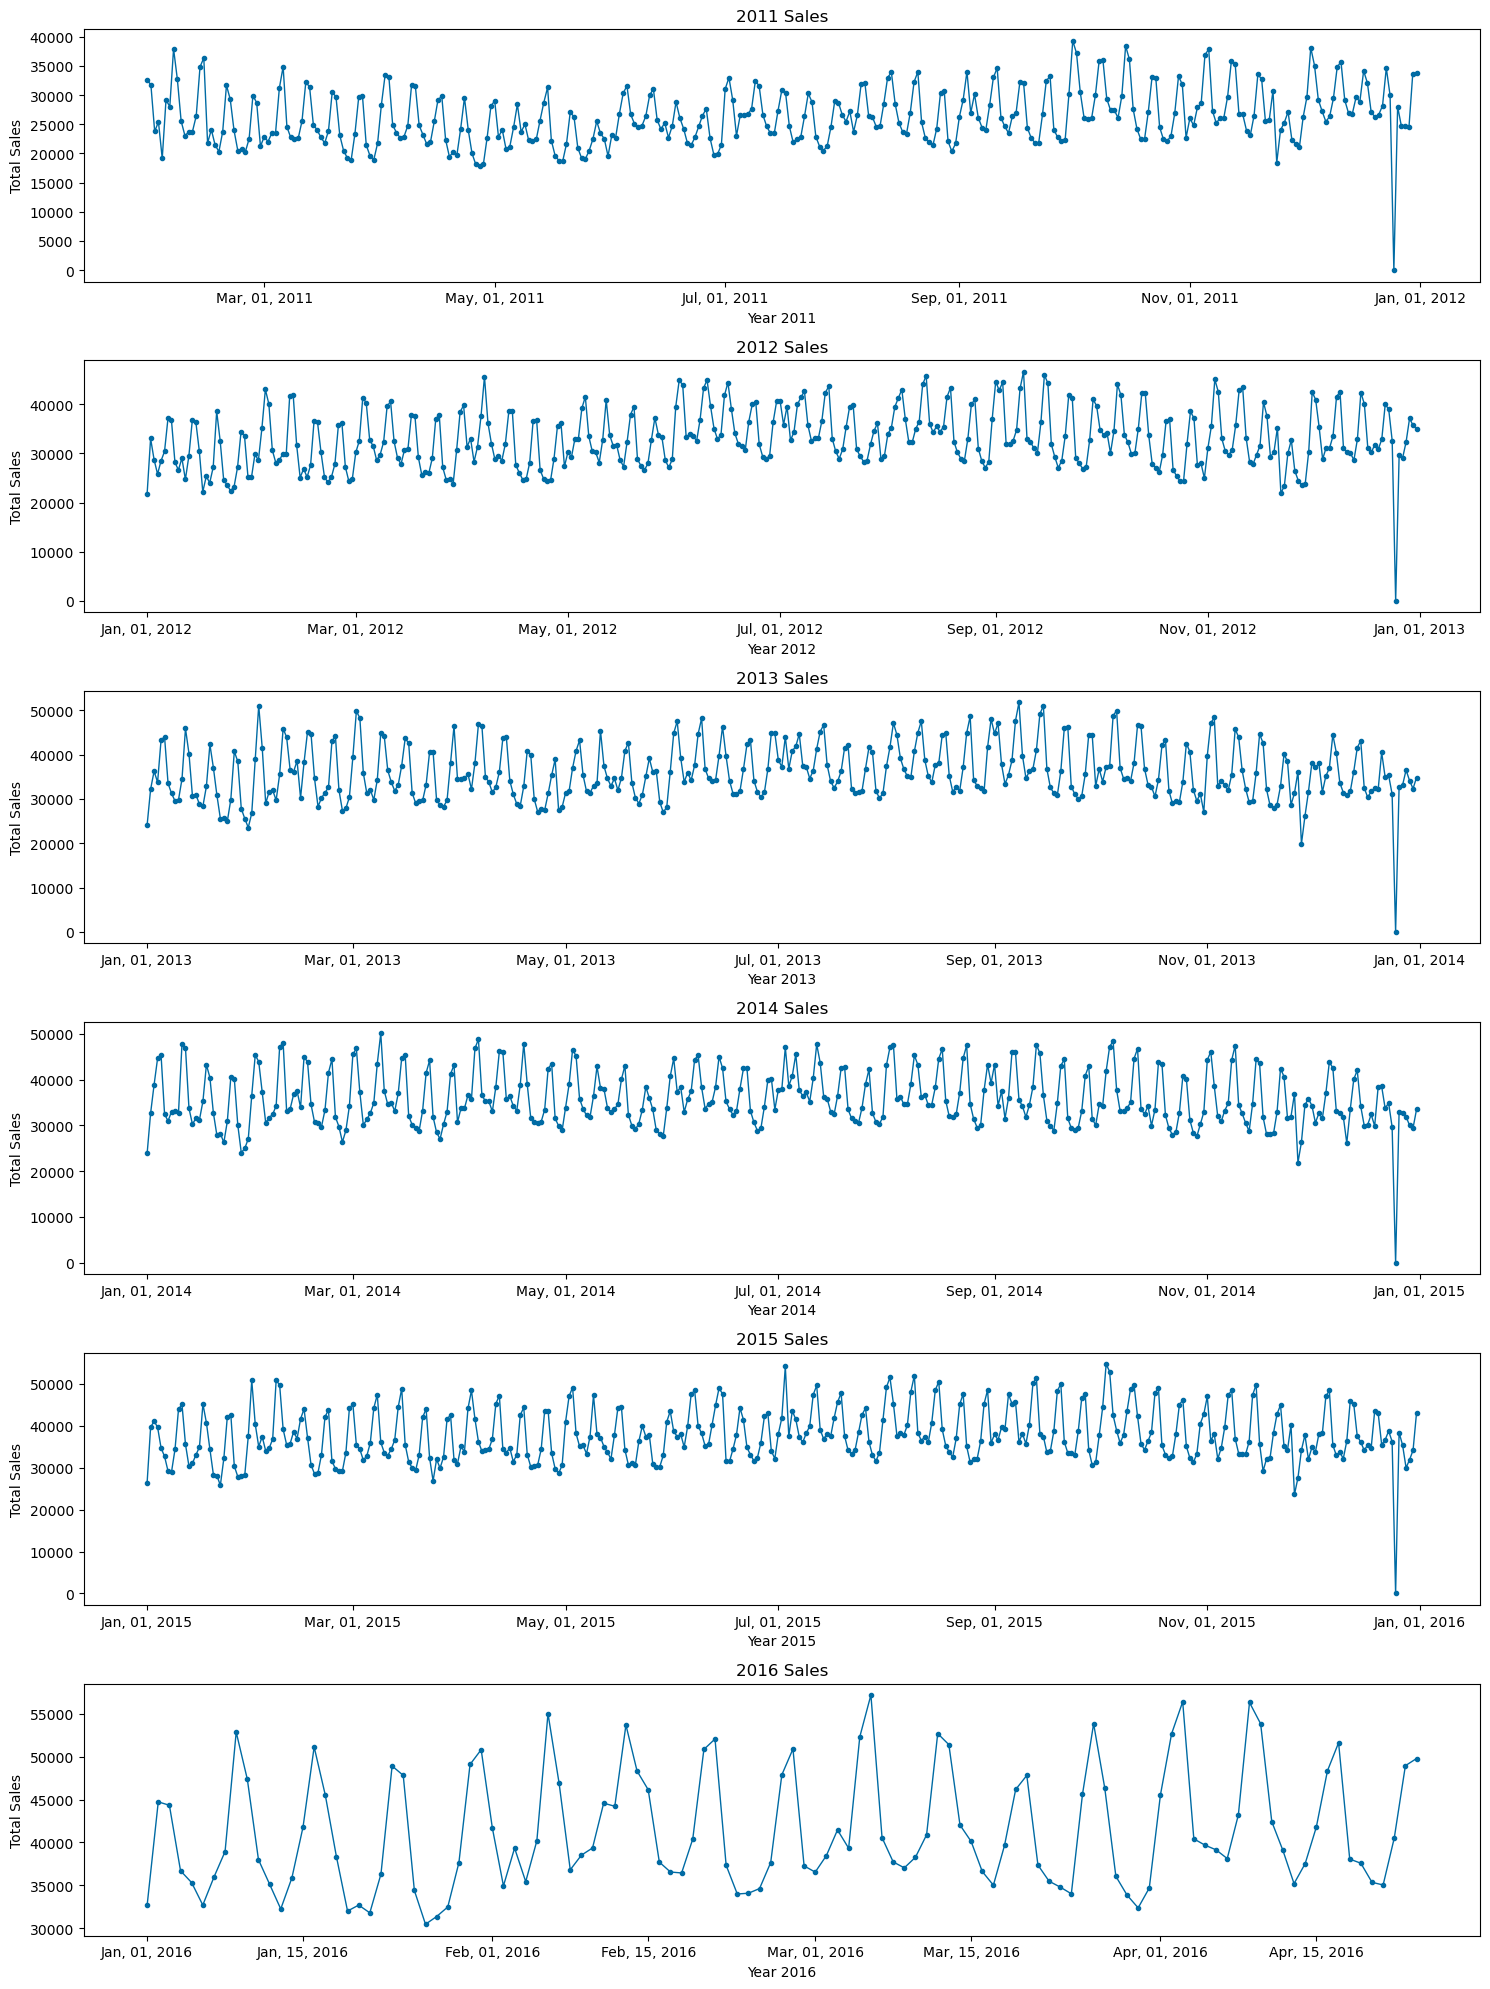

In [13]:
total_sales_per_day['year'] = total_sales_per_day['date'].dt.year
total_sales_per_day_year = total_sales_per_day.groupby(['year'])
gby = total_sales_per_day_year.groups

gby_values_list = list(gby.values())
date_format = mat_dates.DateFormatter('%b, %d, %Y')
fig = plt.figure(figsize=(15, 20))
for i in range(6):
    ax = fig.add_subplot(6,1,i+1)
    plt.plot_date(total_sales_per_day.iloc[gby_values_list[i]]['date'], total_sales_per_day.iloc[gby_values_list[i]]['Total_Sales'],linestyle='solid',linewidth=1,marker='.')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().set_title(str(2011+i)+ ' Sales')
    plt.gca().set_xlabel('Year '+str(2011+i))
    plt.gca().set_ylabel('Total Sales')
plt.tight_layout()
plt.show()